<a href="https://colab.research.google.com/github/Riddars/Dream_team/blob/main/Copy_of_%D0%A5%D0%B0%D0%BA%D0%B0%D1%82%D0%BE%D0%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 32.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np


from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import Descriptors

In [ ]:
# Загрузка данных из CSV файлов
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/data.csv', index_col=0)
bacterial_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/bacterial_descriptors.csv')
drug_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/drug_descriptors.csv', index_col=0)

Смотрим шапки датасетов

# Основной датасет

## data_df download

In [ ]:
print(data_df.info())
data_df.head(2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 883 entries, 0 to 882
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Unnamed: 0                                   883 non-null    int64  
 1   Bacteria                                     883 non-null    object 
 2   NP_Synthesis                                 883 non-null    object 
 3   Drug                                         642 non-null    object 
 4   Drug_class_drug_bank                         642 non-null    object 
 5   Drug_dose                                    577 non-null    float64
 6   NP_concentration                             633 non-null    object 
 7   NP size_min                                  883 non-null    float64
 8   NP size_max                                  883 non-null    float64
 9   NP size_avg                                  883 non-null    float64
 10  sh

,Unnamed: 0,Bacteria,NP_Synthesis,Drug,Drug_class_drug_bank,Drug_dose,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,method,ZOI_drug,ZOI_NP,ZOI_drug_NP,fold_increase_in_antibacterial_activity (%),MDR_check
0,86,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Amoxicillin,Lactams,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1
1,87,Escherichia coli,chem_synthesis_reduction_by_D_maltose,Penicillin,Carboxylic acids and derivatives,NaN,NaN,4.0,10.0,8.0,spherical,MIC,32+,6.3,32+,NaN,1


In [ ]:
## for preprocessing results

def data_df_fix_column_types(df):
    start_len = len(data_df)
    data_df["shape"] = data_df["shape"].astype("category")
    data_df["method"] = data_df["method"].astype("category")

    # 32+ насколько оно больше непонятно, при этом из всего 10 - можно пожертвовать
    # Escherichia coli	, Actinobacillus pleuropneumoniae
    # chem_synthesis_reduction_by_D_maltose
    data_df.drop(
        data_df[data_df.ZOI_drug_NP == '32+'].index, inplace=True)
    data_df.drop(
        data_df[data_df.ZOI_drug == '32+'].index, inplace=True)
    data_df['ZOI_drug'] = data_df.ZOI_drug.astype(float)

    # 50+ замечено 7 штук
    data_df.drop(
        data_df[data_df.ZOI_NP == '50+'].index,inplace=True)
    # # 4000 <- перед ними последнее значение это 220. Из всего 3
    # data_df.drop(
    #     data_df[data_df.ZOI_NP == '4000'].index,inplace=True)
    data_df["ZOI_NP"] = data_df.ZOI_NP.astype(float)


    # 17+2 <- это вероятно 17 +/- 2
    # data_df.drop(
    #     data_df[data_df.ZOI_drug_NP == '17+2'].index, inplace=True)
    data_df["ZOI_drug_NP"] = data_df["ZOI_drug_NP"].replace('17+2', 17)
    data_df["ZOI_drug_NP"] = data_df.ZOI_drug_NP.astype(float)

    # NP_concentration 170/85/*
    '''
    если посмотреть на:
    mask_ = (data_df.NP_concentration.str.contains("170/85/")) | (data_df.NP_concentration == '42.5')
    data_df[mask_].sort_values("Bacteria").set_index("Bacteria")
    такое преобразование выглядит разымным
    '''
    data_df["NP_concentration"] = (data_df["NP_concentration"]
                                        .apply(lambda x : float(str(x).split('/')[-1]))
                                )
    finish_len = len(data_df)
    print("Было удалено :", start_len - finish_len, "строк")


In [ ]:
# def change_nan_to_No_when_possible(data_df):
#     # эксперименты только с наночастицами
#     mask1_ = (data_df.ZOI_drug.isna()) & (data_df.ZOI_drug_NP.isna()) & (~data_df.ZOI_NP.isna()) & (~data_df.NP_concentration.isna())
#     data_df.loc[mask1_, 'Drug_dose'] = 0
#     data_df.loc[mask1_, ['Drug', 'Drug_class_drug_bank']] = ['No', 'No']
#     data_df.loc[mask1_, "ZOI_drug"] = 0
#     data_df.loc[mask1_, "ZOI_drug_NP"] = data_df.loc[mask1_, "ZOI_NP"]

#     # weaker condition
#     mask2_ = (data_df.ZOI_drug.isna()) & (data_df.ZOI_drug_NP.isna()) & (~data_df.ZOI_NP.isna())
#     data_df.loc[mask2_, ['Drug', 'Drug_class_drug_bank']] = ['No', 'No']
#     data_df.loc[mask2_, "ZOI_drug"] = 0

#     # смешанные эксперименты
#     mask3_ = (data_df.ZOI_drug.isna()) & (~data_df.ZOI_drug_NP.isna()) & (data_df.ZOI_NP.isna())
#     # data_df.loc[mask3_, ['ZOI_drug', "ZOI_NP"]] = ['No', 'No'] # ???

#     # эксперименты только с лекарствами
#     mask2_ = (data_df.ZOI_NP.isna()) & (data_df.ZOI_drug_NP.isna()) & (~data_df.ZOI_drug.isna()) & (~data_df.Drug_dose.isna())
#     data_df.loc[mask2_] # а тут ноль экземпляров

In [ ]:
def replace_bacteria_in_data_df(data_df):
    data_df.replace('Bacillus spp.        ', 'Bacillus sp.', inplace=True)
    data_df.replace('Acinetobacter baumanii', 'Acinetobacter baumannii', inplace=True)
    data_df.replace('Actinobacillus pleuropneumoniae ', 'Actinobacillus pleuropneumoniae', inplace=True)
    # data_df.replace('Candida glochares', 'Candida glochares', inplace=True) # ??? заменить само на себя?

    data_df.replace('Enterobacter cloacae ', 'Enterobacter cloacae', inplace=True)
    data_df.replace('Salmonella  typhi', 'Salmonella typhi', inplace=True)
    data_df.replace('Salmonella Paratyphi', 'Salmonella enterica', inplace=True) # https://www.ncbi.nlm.nih.gov/datasets/taxonomy/54388/
    # data_df.replace('Serratia marcescens', 'Serratia marcescens', inplace=True)  # ??? заменить само на себя?


    # unrecoverable
    data_df.drop(
        data_df[
            (data_df.Bacteria == 'Serratia marcescens') | ((data_df.Bacteria == 'Candida glochares'))
        ].index,
        inplace=True
    )


In [ ]:
def drop_fold_increase_in_antibacterial_activity(df):
    df.drop(columns='fold_increase_in_antibacterial_activity (%)', inplace=True)

# drop_fold_increase_in_antibacterial_activity(data_df)

In [ ]:
data_df.isna().sum()

Unnamed: 0                                       0
Bacteria                                         0
NP_Synthesis                                     0
Drug                                           241
Drug_class_drug_bank                           241
Drug_dose                                      306
NP_concentration                               250
NP size_min                                      0
NP size_max                                      0
NP size_avg                                      0
shape                                            0
method                                           0
ZOI_drug                                       256
ZOI_NP                                         442
ZOI_drug_NP                                    299
fold_increase_in_antibacterial_activity (%)    462
MDR_check                                        0
dtype: int64

In [ ]:
def prepare_data_df(data_df):
    data_df.set_index('Unnamed: 0', inplace=True) # чтобы можно было дентифизировать элементы
    data_df_fix_column_types(data_df)
    replace_bacteria_in_data_df(data_df)
    # drop_fold_increase_in_antibacterial_activity(df)

prepare_data_df(data_df)

Было удалено : 17 строк


## изучаем датасет бактерий


Вспомогательный датасет 2 (бактерии)

In [ ]:
bacterial_descriptors_df.head(2)

,Tax_id,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.0,36.0,48.0,37,2,urine
1,['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,24.0,36.0,48.0,37,2,lungs


In [ ]:
# смотрим каких названий из data_df нет в bacterial_descriptors
set(data_df['Bacteria'].unique()) - set(bacterial_descriptors_df['Bacteria'].unique())

# а вот избыточных много
# set(bacterial_descriptors_df['Bacteria'].unique()) - set(data_df['Bacteria'].unique())

set()

In [ ]:
# fix some grams
def popluate_missing_gram_in_bacteria_descriplots(bacterial_descriptors_df):
    bacterial_descriptors_df[bacterial_descriptors_df.gram.isna()].Bacteria.value_counts()

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
            ['Candida albicans',
            'Candida glabrata',
            'Candida saitoana',
            'Micrococcus luteus',
            'Staphylococcus aureus'
            'Staphylococcus epidermidis',
            'Bacillus subtilis',
            'Bacillus sp.',
            ])
    , 'gram'
    ] = 'p'

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
    [
                'Neisseria mucosa',
                'Escherichia coli',
                'Salmonella enterica',
                'Salmonella typhi',
                'Klebsiella pneumonia',
                'Pseudomonas aeruginosa',
                'Vibrio parahaemolyticus',
                'Serratia odorifera',
                'Pseudomonas koreensis',
                'Haemophilus influenzae',
            ])
    , 'gram'
    ] = 'n'


In [ ]:
def convert_gram_to_valeus(df):
    df['gram'] = df.gram.map({'p': 1, 'n': -1})
    # .astype(int)

In [ ]:
# prepare_bacteria_dataset
def prepare_bacteria_descriptors_df(bacteria_descriptors):

    popluate_missing_gram_in_bacteria_descriplots(bacteria_descriptors)
    # https://link.springer.com/article/10.1007/s00253-010-2810-1
    # меньше инкубационного периода не нашлось
    bacterial_descriptors_df.loc[bacterial_descriptors_df.Bacteria == 'Serratia odorifera', 'min_Incub_period, h'] = 12
    convert_gram_to_valeus(bacteria_descriptors)

prepare_bacteria_descriptors_df(bacterial_descriptors_df)

## Вспомогательный датасет 3 (антибиотики)

In [ ]:
drug_descriptors_df.head(2)

,drug,chemID,prefered_name,smiles
0,Amoxicillin,CHEMBL1082,AMOXICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...
1,Penicillin,CHEMBL1223,PENICILLIN G POTASSIUM,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...


In [ ]:
# Функция для добавления столбца с дескрипторами к датасету
def calculate_descriptors(df, smiles_column, descriptor_list):
    for descriptor_name in descriptor_list:
        descriptor_values = [getattr(Descriptors, descriptor_name)(Chem.MolFromSmiles(smiles)) for smiles in df[smiles_column]]
        df[descriptor_name] = pd.Series(np.array(descriptor_values), index=df.index)

    return df

Очевидно важными параметрами являются 'MolWt', 'MolLogP', Бета-лактамы - 'fr_lactam' Макролиды содержат макроциклическое лактонное кольцо - 'fr_lactone' тетрациклины - 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles' Аминогликозиды - 'NHOHCount' Гликопептиды - пока непонятно, надо считать количество пептидных связей Остальные - позже

In [ ]:
def get_additional_descriptors(drug_descriptors_df):
    descriptor_list = ['MolWt', 'MolLogP','fr_lactam','fr_lactone','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NHOHCount']
    rv = calculate_descriptors(drug_descriptors_df, 'smiles', descriptor_list)
    drug_descriptors_df.drop(columns=["chemID", "prefered_name", "smiles"], inplace=True)
    return rv


def prepare_drug_df(drug_descriptors_df):
    get_additional_descriptors(drug_descriptors_df)
    drug_descriptors_df.rename({"drug":"Drug"}, axis=1, inplace=True)

prepare_drug_df(drug_descriptors_df)
# descriptor_list = ['MolWt', 'MolLogP','fr_lactam','fr_lactone','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NHOHCount']
# drug_descriptors_list = descriptor_list
# drug_descriptors_df1 = calculate_descriptors(drug_descriptors_df, 'smiles', descriptor_list)

In [ ]:
# drug_descriptors_df1.head()

Смотрим описание основного датасета

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 863 entries, 638 to 882
Data columns (total 16 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   Bacteria                                     863 non-null    object  
 1   NP_Synthesis                                 863 non-null    object  
 2   Drug                                         624 non-null    object  
 3   Drug_class_drug_bank                         624 non-null    object  
 4   Drug_dose                                    576 non-null    float64 
 5   NP_concentration                             630 non-null    float64 
 6   NP size_min                                  863 non-null    float64 
 7   NP size_max                                  863 non-null    float64 
 8   NP size_avg                                  863 non-null    float64 
 9   shape                                        863 non-null    ca

Merge all

In [ ]:
df = data_df.reset_index().merge(bacterial_descriptors_df, how='left', on='Bacteria').set_index('Unnamed: 0')

In [ ]:
df = df.reset_index().merge(drug_descriptors_df, how='left', on='Drug').set_index('Unnamed: 0')
# где нет лекарства
# df.loc[df.smiles.isna(), drug_descriptors_list] = ['No'] * len(drug_descriptors_list)


# set(df['Drug'].unique()) - set(df['Drug'].unique()), df["Drug"].value_counts()["Neomycin"]

df.drop(
    df[df.Drug == 'Neomycin'].index, inplace= True
)

# Feature инжиринг

In [ ]:
# add graph distances to dataset

import networkx as nx

bacteria_taxonomy_descriptors = [
    'kingdom', 'subkingdom', 'clade',
    'phylum', 'class', 'order', 'family', 'genus', 'Bacteria']
# добавить расстояния на графе таксономии
def make_graph_better(bacterial_descriptors_df):
    '''
    Строит филогенетический граф
    '''
    tax_df = bacterial_descriptors_df.loc[:,bacteria_taxonomy_descriptors] # копирует
    gg_ = nx.Graph()
    for top_node in tax_df['kingdom']: # чтобы был связным
        gg_.add_edge('root', top_node)

    for parents, childs in zip(bacteria_taxonomy_descriptors, bacteria_taxonomy_descriptors[1:]):
        tax_df[childs] = tax_df.loc[:, [childs]].fillna(childs) # уникальный NaN для кадждого столбца
        edge_lst = tax_df[[parents, childs]].values
        gg_.add_edges_from(edge_lst)

    # gg_.remove_node(np.nan)
    # nx.draw_spring(gg_)
    return gg_


def get_distances(bacterial_descriptors_df, df):
    '''Берёт из графа расстояния и отфильтровывает только нужные
    '''
    g_= make_graph_better(bacterial_descriptors_df)
    lengths = dict(nx.all_pairs_shortest_path_length(g_))
    rv = {key: lengths[key] for key in df.Bacteria.unique()}
    return rv


def populate_distances_to_df(bacterial_descriptors_df,
                             df):
    df = df.copy()
    distances = get_distances(bacterial_descriptors_df, df)
    for bacteria in distances.keys():
        df['d_to_' + bacteria] = df.Bacteria.map(distances[bacteria])
    # return df.loc[:, df.columns.str.startswith('d_to_')] # посмотреть на расстояния
    return df

def remove_bacteria_taxonomy_descriptors_from_df(df):
    df.drop(columns=bacteria_taxonomy_descriptors[:-2], inplace=True)



In [ ]:
def add_distances_on_graph_to_df(bacterial_descriptors_df, df):
    df = populate_distances_to_df(bacterial_descriptors_df, df)
    remove_bacteria_taxonomy_descriptors_from_df(df)

add_distances_on_graph_to_df(bacterial_descriptors_df, df)

# Feature selection

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


(854, 37)


<Axes: >

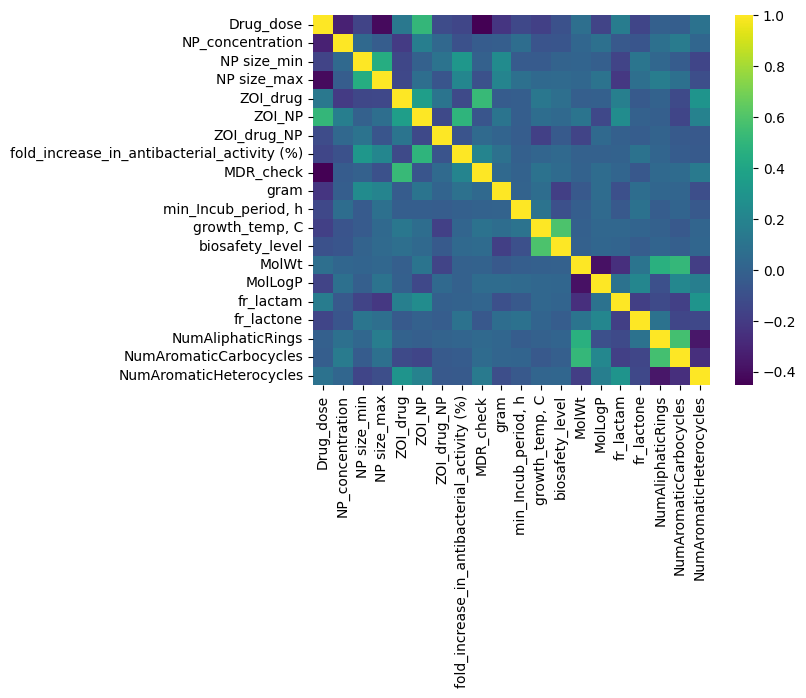

In [ ]:
# # оставить только некоторые расстояния между бактериями - те, что меньшще всего коррелируют
def correlation(data, threshold=None):
    # https://github.com/anujdutt9/Feature-Selection-for-Machine-Learning/blob/master/Filter%20Methods/Correlation.ipynb
    # Set of all names of correlated columns
    col_corr = set()
    corr_mat = data.corr()
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if (abs(corr_mat.iloc[i,j]) > threshold):
                colname = corr_mat.columns[i]
                col_corr.add(colname)
    return col_corr

def remove_highly_correlated_features_from_df(df):
    # изначально только чтобы остачить только несколько расстояний между бактериями
    correlated_features = correlation(data=df, threshold=0.80)
    len(set(correlated_features))
    df = df[df.columns.drop(correlated_features)]
    return df

df = remove_highly_correlated_features_from_df(df)
print(df.shape)
sns.heatmap(df.corr(), cmap='viridis', yticklabels=True)


In [ ]:
# это всё-таки приходится делать
def filter_features(df):
    remove_bacteria_taxonomy_descriptors_from_df(df)
    drop_fold_increase_in_antibacterial_activity(df)

filter_features(df)


### попытка нарисовать филогенетический граф с количеством семплов на каждый вид

In [ ]:
# # добавить ещё и квадраты числовых величин
# # не выжили при проверке на корреляции 0.80

# def add_squared_faetures(df=df):
#     df.loc["NP size_min_2"] = np.square(df["NP size_min"])
#     df.loc["NP size_max_2"] = np.square(df["NP size_max"])
#     df.loc["ZOI_drug_2"] = np.square(df["ZOI_drug"])
#     df.loc["ZOI_drug_2"] = np.square(df["ZOI_drug"])
#     df.loc["ZOI_NP"] = np.square(df["ZOI_NP"])
#     df.loc["fold_increase_in_antibacterial_activity (%)_2"] = np.square(df["fold_increase_in_antibacterial_activity (%)"])
#     df.loc["min_Incub_period, h_2"] = np.square(df["min_Incub_period, h"])
#     df.loc["growth_temp_2"] = np.square(df["growth_temp, C"])

#     df.loc["d_to_Micrococcus luteus_2"] = np.square(df["d_to_Micrococcus luteus"])
#     df.loc["d_to_Neisseria mucosa_2"] = np.square(df["d_to_Neisseria mucosa"])
#     df.loc["d_to_Candida albicans"] = np.square(df["d_to_Candida albicans"])

# # не выжили после проверки на корреляцию 0.80
# print(df.shape)
# add_squared_faetures()
# df = drop_correlations(df)
# print(df.shape)

# sns.heatmap(df.corr(), cmap='viridis', yticklabels=True)

In [ ]:
# # как нарисовать дерево https://stackoverflow.com/questions/57512155/how-to-draw-a-tree-more-beautifully-in-networkx
# # вариант 2: https://plotly.com/python/tree-plots/
# tree_ = make_graph_better()
# leafes = [x for x in tree_.nodes() if tree_.degree(x) == 1]
# weights = df.Bacteria.value_counts()
# for l in leafes:
#     tree_.nodes[l]['weight'] = weights[l

# # nx.draw_circular(tree_)

# Imputation

In [ ]:
assert len(df.loc[(df == 'No').any(axis=1)]) == 0

In [ ]:
only_one_Nan_per_row = df.loc[
    (df.isna().sum(axis=1) == 1)
    ]
only_one_Nan_per_row.isna().sum()

Bacteria                     0
NP_Synthesis                 0
Drug                         0
Drug_class_drug_bank         0
Drug_dose                    8
NP_concentration             0
NP size_min                  0
NP size_max                  0
shape                        0
method                       0
ZOI_drug                     0
ZOI_NP                     379
ZOI_drug_NP                  0
MDR_check                    0
Tax_id                       0
genus                        0
species                      0
gram                         0
min_Incub_period, h          0
growth_temp, C               0
biosafety_level              0
isolated_from                0
MolWt                        0
MolLogP                      0
fr_lactam                    0
fr_lactone                   0
NumAliphaticRings            0
NumAromaticCarbocycles       0
NumAromaticHeterocycles      0
dtype: int64

In [ ]:
import plotly.express as px
fig = px.histogram(df, x="Drug_dose", marginal="rug", color=df.ZOI_NP.isna())
fig.show()


In [ ]:
fig = px.density_contour(df, x="Drug", y="ZOI_drug", marginal_x="histogram", marginal_y="histogram", color=(df.isna().sum(axis=1) == 1) & (df.Drug_dose.isna()))
fig.show()



<ipython-input-82-b80a9ec3414c>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



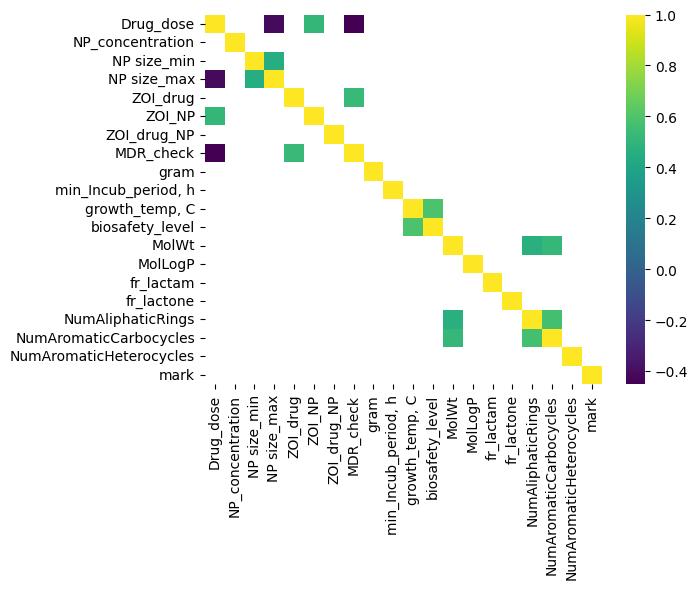

In [ ]:
df_ = df.copy()
df_['mark'] = df.Drug_dose.isna()
corr = df_.corr()
# corr = corr[np.abs(corr) > 0.5]
sns.heatmap(corr, cmap='viridis', yticklabels=True, mask = np.abs(corr) < 0.4)
# сильно коррелирует отсутствие значения только с Drug_dose

part_df = df[[
    'NP_concentration',
    'NP size_min',
    'NP size_max',
    "MDR_check",
    "gram",
    "min_Incub_period, h",
    "growth_temp, C",
]]



In [ ]:
fig = px.histogram(df, x="", marginal="rug", color=((df.isna().sum(axis=1) == 1)) & (df.ZOI_NP.isna()))
fig.show()


ValueError: ignored

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

def impute_data(data_df_drug_extended):
    index = data_df_drug_extended.index.copy()
    drug_data = data_df_drug_extended.select_dtypes(np.number)  # для удобства

    drug_scaler = MinMaxScaler()
    drug_scaler.fit(drug_data.dropna())
    drug_data_transformed = drug_scaler.transform(drug_data)

    drug_imputer = KNNImputer(n_neighbors=5, weights='distance')
    drug_imputer.fit(
        drug_scaler.transform(drug_data.dropna())
    )
    imputed = drug_imputer.transform(drug_data_transformed)

    imputed_drug_part = pd.DataFrame(
        drug_scaler.inverse_transform(imputed), columns=drug_scaler.get_feature_names_out()
    )

    imputed_drug_part['index'] = index
    imputed_drug_part.set_index('index', inplace=True)
    categorical_columns = data_df_drug_extended.columns.drop(drug_data.columns)
    imputed_drug_part[categorical_columns] = data_df_drug_extended[categorical_columns]
    assert (data_df_drug_extended.index == imputed_drug_part.index).all()

    return imputed_drug_part


In [ ]:
# impute Drug_dose
def impure_one_missing_param(df, param):
    missing_cond = ((df[param].isna()) & (df.isna().sum(axis=1) == 1))
    reference_cond = (df.isna().sum(axis=1) == 0)
    df_ = df[
        missing_cond | reference_cond
    ]
    print(df_.shape)
    drug_data_imputed = impute_data(df_)
    df.loc[missing_cond, param] = drug_data_imputed[[param]]

impure_one_missing_param(df, 'Drug_dose')
impure_one_missing_param(df, 'ZOI_NP')



(60, 29)
(439, 29)


In [ ]:
# df.isna().sum(axis=1).unique() # 2 3 4 11 12 13
df[
    (df.isna().sum(axis=1) == 2)
     & (~df.Drug_dose.isna())
    # & (df.NP_concentration.isna())
    & (df.ZOI_drug.isna())
].isna().sum()
# impure_one_missing_param()



Bacteria                    0
NP_Synthesis                0
Drug                        0
Drug_class_drug_bank        0
Drug_dose                   0
NP_concentration            0
NP size_min                 0
NP size_max                 0
shape                       0
method                      0
ZOI_drug                   14
ZOI_NP                     14
ZOI_drug_NP                 0
MDR_check                   0
Tax_id                      0
genus                       0
species                     0
gram                        0
min_Incub_period, h         0
growth_temp, C              0
biosafety_level             0
isolated_from               0
MolWt                       0
MolLogP                     0
fr_lactam                   0
fr_lactone                  0
NumAliphaticRings           0
NumAromaticCarbocycles      0
NumAromaticHeterocycles     0
dtype: int64

In [ ]:
missing_cond = ((df['ZOI_drug'].isna()) & (df.isna().sum(axis=1) == 2) & (~df['ZOI_NP'].isna()))
reference_cond = (df.isna().sum(axis=1) == 0)
df_ = df[
    missing_cond | reference_cond
]
print(df_.shape)
drug_data_imputed = impute_data(df_)
df.loc[missing_cond, 'ZOI_drug'] = drug_data_imputed[['ZOI_drug']]

(439, 29)


ValueError: ignored

# Функция split - разделение на тест и трейн

In [ ]:
#пока сделаем OneHot
df = df.drop(columns = ['ZOI_NP','drug'])
condition = ((df['method'] == 'disc_diffusion') | (df['method'] == 'well_diffusion'))
df1 = df[condition]
df2 = df[~condition]
df1=df1.dropna()
df5=pd.get_dummies(df1)
df5.info()

In [ ]:
target = "ZOI_drug_NP"
def split(df, target):
  X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = target,axis=1), df[target], test_size=0.3, random_state=42)
  cols = df.columns.tolist()
  columns_to_remove = [target]
  cols = list(filter(lambda x: x not in columns_to_remove, cols))
  from sklearn.preprocessing import MinMaxScaler
  scaler = MinMaxScaler()
  sclr = scaler.fit(X_train)
  X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
  X_test = pd.DataFrame(scaler.transform(X_test), columns=cols)
  return (X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = split(df5,target)

# Функция Random Forest

In [ ]:
from sklearn.metrics import  mean_squared_error
def RF(X_train, y_train, X_test, y_test):
  regr = RandomForestRegressor(random_state=0, n_estimators=174, max_depth=15, oob_score = True)
  regr.fit(X_train, y_train)
  explainer = shap.TreeExplainer(regr)
  shap_values = explainer(X_train)
  predicted = regr.predict(X_test)

  fig, ax = plt.subplots()
  ax.scatter(y_test, predicted, edgecolors=(0, 0, 0))
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

  mse = mean_squared_error(y_test, predicted)
  rmse = np.sqrt(mse)

   # Рассчет RMSE в процентах
  rmse_percentage = (rmse / np.mean(y_test)) * 100

  # Вывод результатов
  print("RMSE:", rmse)
  print("RMSE в процентах:", rmse_percentage)
  print(r2_score(y_test, predicted))
  shap.summary_plot(shap_values, X_train, plot_type='bar')
  return(regr)

In [ ]:
r = RF(X_train, y_train, X_test, y_test)

In [ ]:
df5.info()

# Что пытался делать **Арсен**

In [ ]:
# df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/Final(no).csv', index_col=0)

In [ ]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import train_test_split
# # Удаление строк с пропущенными значениями
# df.dropna(inplace=True)
# # Разделение данных на признаки (X) и целевую переменную (y)
# X = df[['NP_concentration', 'NP size_min', 'NP size_max', 'ZOI_drug', 'MDR_check']]
# y = df['ZOI_drug_NP']
# # Шкалирование признаков с использованием стандартного масштабирования
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# # Импьютация пропущенных значений с использованием средних значений
# imputer = SimpleImputer(strategy='mean')
# X_imputed = imputer.fit_transform(X_scaled)

# # Разделение данных на обучающий и тестовый наборы
# X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

In [ ]:
# # Импорт необходимых библиотек
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# import matplotlib.pyplot as plt
# import numpy as np

# # Разделение данных на признаки (X) и целевую переменную (y)
# X = df[['NP_concentration', 'NP size_min', 'NP size_max', 'ZOI_drug', 'MDR_check']]
# y = df['ZOI_drug_NP']

# # Разделение данных на обучающий и тестовый наборы
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Создание и обучение модели линейной регрессии
# model = LinearRegression()
# model.fit(X_train, y_train)

# # Предсказание на тестовом наборе
# y_pred = model.predict(X_test)

# # Вычисление среднеквадратичной ошибки (MSE)
# mse = mean_squared_error(y_test, y_pred)
# print('Среднеквадратичная ошибка:', mse)

# # Рассчитываем коэффициент детерминации
# r2 = r2_score(y_test, y_pred)
# print('Коэффициент детерминации (R^2):', r2)

# # Визуализация рассеяния фактических значений и предсказанных значений
# plt.scatter(y_test, y_pred)
# plt.xlabel('Фактические значения')
# plt.ylabel('Предсказанные значения')
# plt.title('Рассеяние: Фактические значения vs Предсказанные значения')
# plt.show()

# # Визуализация линии регрессии
# plt.plot(y_test, y_test, color='red', label='Идеальное соответствие')
# plt.plot(y_test, y_pred, 'o', color='blue', label='Линия регрессии')
# plt.xlabel('Фактические значения')
# plt.ylabel('Предсказанные значения')
# plt.title('Линия регрессии: Фактические значения vs Предсказанные значения')
# plt.legend()
# plt.show()

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Загрузка данных из CSV файла
# data = df

# # Разделение на признаки и целевую переменную
# X = data.drop('ZOI_drug_NP', axis=1)
# y = data['ZOI_drug_NP']

# # Масштабирование признаков
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df.drop(columns=["species", "genus", "family", "order", "class", "kingdom", "phylum", "ZOI_drug_NP"]))

# # Разделение на обучающую и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Создание модели нейронной сети
# model = keras.Sequential([
#     keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     keras.layers.Dropout(0.2),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(1)
# ])

# # Компиляция модели с метрикой accuracy
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# # Обучение модели
# history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

# # Оценка модели на тестовой выборке
# loss, accuracy = model.evaluate(X_test, y_test)

# # Вывод результатов
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)

# # Построение графика обучения
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
# plt.show()

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Создание экземпляра OneHotEncoder
# encoder = OneHotEncoder(sparse=False)

# # Преобразование категориальных признаков методом OneHotEncoding
# encoded_features = encoder.fit_transform(df[categorical_features])

# # Получение имен категорий
# feature_names = encoder.get_feature_names_out(categorical_features)

# # Создание датафрейма из преобразованных признаков с префиксом "encoded_"
# encoded_df = pd.DataFrame(encoded_features, columns=[f'encoded_{name}' for name in feature_names])

# # Переименование столбцов в encoded_df (если необходимо)
# encoded_df = encoded_df.rename(columns={'old_name': 'new_name'})

# # Объединение преобразованных признаков с исходным датафреймом
# df = pd.concat([df, encoded_df])

# # Удаление исходных категориальных признаков
# df = df.drop(columns=categorical_features)

In [ ]:
cat = r'''
 /\_/\
( o.o )
 > ^ <
'''

print(cat)

# вторая попытка в немного в другом стиле (Лев)

## get data_df

In [ ]:
## for preprocessing results

def data_df_fix_column_types(df):
    start_len = len(data_df)
    data_df["shape"] = data_df["shape"].astype("category")
    data_df["method"] = data_df["method"].astype("category")

    # 32+ насколько оно больше непонятно, при этом из всего 10 - можно пожертвовать
    # Escherichia coli	, Actinobacillus pleuropneumoniae
    # chem_synthesis_reduction_by_D_maltose
    data_df.drop(
        data_df[data_df.ZOI_drug_NP == '32+'].index, inplace=True)
    data_df.drop(
        data_df[data_df.ZOI_drug == '32+'].index, inplace=True)
    data_df['ZOI_drug'] = data_df.ZOI_drug.astype(float)

    # 50+ замечено 7 штук
    data_df.drop(
        data_df[data_df.ZOI_NP == '50+'].index,inplace=True)
    # # 4000 <- перед ними последнее значение это 220. Из всего 3
    # data_df.drop(
    #     data_df[data_df.ZOI_NP == '4000'].index,inplace=True)
    data_df["ZOI_NP"] = data_df.ZOI_NP.astype(float)


    # 17+2 <- это вероятно 17 +/- 2
    # data_df.drop(
    #     data_df[data_df.ZOI_drug_NP == '17+2'].index, inplace=True)
    data_df["ZOI_drug_NP"] = data_df["ZOI_drug_NP"].replace('17+2', 17)
    data_df["ZOI_drug_NP"] = data_df.ZOI_drug_NP.astype(float)

    # NP_concentration 170/85/*
    '''
    если посмотреть на:
    mask_ = (data_df.NP_concentration.str.contains("170/85/")) | (data_df.NP_concentration == '42.5')
    data_df[mask_].sort_values("Bacteria").set_index("Bacteria")
    такое преобразование выглядит разымным
    '''
    data_df["NP_concentration"] = (data_df["NP_concentration"]
                                        .apply(lambda x : float(str(x).split('/')[-1]))
                                )
    finish_len = len(data_df)
    print("Было удалено :", start_len - finish_len, "строк")


In [ ]:
def replace_bacteria_in_data_df(data_df):
    data_df.replace('Bacillus spp.        ', 'Bacillus sp.', inplace=True)
    data_df.replace('Acinetobacter baumanii', 'Acinetobacter baumannii', inplace=True)
    data_df.replace('Actinobacillus pleuropneumoniae ', 'Actinobacillus pleuropneumoniae', inplace=True)
    # data_df.replace('Candida glochares', 'Candida glochares', inplace=True) # ??? заменить само на себя?

    data_df.replace('Enterobacter cloacae ', 'Enterobacter cloacae', inplace=True)
    data_df.replace('Salmonella  typhi', 'Salmonella typhi', inplace=True)
    data_df.replace('Salmonella Paratyphi', 'Salmonella enterica', inplace=True) # https://www.ncbi.nlm.nih.gov/datasets/taxonomy/54388/
    # data_df.replace('Serratia marcescens', 'Serratia marcescens', inplace=True)  # ??? заменить само на себя?


    # unrecoverable
    data_df.drop(
        data_df[
            (data_df.Bacteria == 'Serratia marcescens') | ((data_df.Bacteria == 'Candida glochares'))
        ].index,
        inplace=True
    )


In [ ]:
data_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/data.csv', index_col=0)
data_df.set_index('Unnamed: 0') # чтобы можно было дентифизировать элементы
data_df_fix_column_types(data_df)
replace_bacteria_in_data_df(data_df)
# data_df.head(2)

Было удалено : 17 строк


## get bacteria_descriptors_df

In [ ]:
# fix some grams
def popluate_missing_gram_in_bacteria_descriplots(bacterial_descriptors_df):
    bacterial_descriptors_df[bacterial_descriptors_df.gram.isna()].Bacteria.value_counts()

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
            ['Candida albicans',
            'Candida glabrata',
            'Candida saitoana',
            'Micrococcus luteus',
            'Staphylococcus aureus'
            'Staphylococcus epidermidis',
            'Bacillus subtilis',
            'Bacillus sp.',
            ])
    , 'gram'
    ] = 'p'

    bacterial_descriptors_df.loc[
        bacterial_descriptors_df.Bacteria.isin(
    [
                'Neisseria mucosa',
                'Escherichia coli',
                'Salmonella enterica',
                'Salmonella typhi',
                'Klebsiella pneumonia',
                'Pseudomonas aeruginosa',
                'Vibrio parahaemolyticus',
                'Serratia odorifera',
                'Pseudomonas koreensis',
                'Haemophilus influenzae',
            ])
    , 'gram'
    ] = 'n'


In [ ]:
# расстояние на бактериях
import networkx as nx

bacteria_taxonomy_descriptors = [
    'kingdom', 'subkingdom', 'clade',
    'phylum', 'class', 'order', 'family', 'genus', 'Bacteria']
# добавить расстояния на графе таксономии
def make_graph_better(bacterial_descriptors_df):
    '''
    Строит филогенетический граф
    '''
    tax_df = bacterial_descriptors_df.loc[:,bacteria_taxonomy_descriptors] # копирует
    gg_ = nx.Graph()
    for top_node in tax_df['kingdom']: # чтобы был связным
        gg_.add_edge('root', top_node)

    for parents, childs in zip(bacteria_taxonomy_descriptors, bacteria_taxonomy_descriptors[1:]):
        tax_df[childs] = tax_df.loc[:, [childs]].fillna(childs) # уникальный NaN для кадждого столбца
        edge_lst = tax_df[[parents, childs]].values
        gg_.add_edges_from(edge_lst)

    # gg_.remove_node(np.nan)
    # nx.draw_spring(gg_)
    return gg_


def get_distances(bacterial_descriptors_df, df):
    '''Берёт из графа расстояния и отфильтровывает только нужные
    '''
    g_= make_graph_better(bacterial_descriptors_df)
    lengths = dict(nx.all_pairs_shortest_path_length(g_))
    rv = {key: lengths[key] for key in df.Bacteria.unique()}
    return rv


def populate_distances_to_df(df,bacterial_descriptors_df):
    df = df.copy()
    distances = get_distances(bacterial_descriptors_df, df)
    for bacteria in distances.keys():
        df['d_to_' + bacteria] = df.Bacteria.map(distances[bacteria])
    # return df.loc[:, df.columns.str.startswith('d_to_')] # посмотреть на расстояния
    return df

def remove_bacteria_taxonomy_descriptors_from_df(df):
    df.drop(columns=bacteria_taxonomy_descriptors[:-2], inplace=True)

# bacterial_descriptors_df = populate_distances_to_df(bacterial_descriptors_df, df)
# remove_bacteria_taxonomy_descriptors_from_df(df)



In [ ]:
bacterial_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/bacterial_descriptors.csv')
popluate_missing_gram_in_bacteria_descriplots(bacterial_descriptors_df)
bacterial_descriptors_df.head(2)

,Tax_id,Bacteria,kingdom,subkingdom,clade,phylum,class,order,family,genus,species,gram,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,isolated_from
0,['470'],Acinetobacter baumannii,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Moraxellales,Moraxellaceae,Acinetobacter,Acinetobacter calcoaceticus/baumannii complex,n,24.0,36.0,48.0,37,2,urine
1,['715'],Actinobacillus pleuropneumoniae,Bacteria,NaN,NaN,Pseudomonadota,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Actinobacillus,Actinobacillus pleuropneumoniae,n,24.0,36.0,48.0,37,2,lungs


## get drug representation with additional

In [ ]:
# Функция для добавления столбца с дескрипторами к датасету
def calculate_descriptors(df, smiles_column, descriptor_list):
    for descriptor_name in descriptor_list:
        descriptor_values = [getattr(Descriptors, descriptor_name)(Chem.MolFromSmiles(smiles)) for smiles in df[smiles_column]]
        df[descriptor_name] = pd.Series(np.array(descriptor_values), index=df.index)

    return df

In [ ]:
drug_descriptors_df = pd.read_csv('https://raw.githubusercontent.com/Riddars/Hakaton/main/drug_descriptors.csv', index_col=0)

def get_additional_descriptors(drug_descriptors_df=drug_descriptors_df):
    descriptor_list = ['MolWt', 'MolLogP','fr_lactam','fr_lactone','NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles','NHOHCount']
    calculate_descriptors(drug_descriptors_df, 'smiles', descriptor_list)
    drug_descriptors_df.drop(columns=["chemID", "prefered_name", "smiles"], inplace=True)


def prepare_drug_df(drug_descriptors_df=drug_descriptors_df):
    drug_descriptors_df.rename({"drug":"Drug"}, axis=1, inplace=True)

get_additional_descriptors()
prepare_drug_df()
drug_descriptors_df.head(2)

,Drug,MolWt,MolLogP,fr_lactam,fr_lactone,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NHOHCount
0,Amoxicillin,365.411,0.0237,1,0,2,1,0,5
1,Penicillin,372.487,-3.4699,1,0,2,1,0,1


## разделение данных на части для заполнения пропусков


In [ ]:
'''
формат данных:
Drug_dataset:
Bacteria, Drug, Drug_class_drug_bank, Drug_dose, ZOI_drug

NP_dataset:
Bacteria, NP_concentration, NP size_min, NP size_max, NP size_avg, shape, ZOI_NP

drug_and_NP:
Bacteria, Drug, Drug_class_drug_bank, Drug_dose,
NP_concentration, NP size_min, NP size_max, NP size_avg, shape,
ZOI_drug_NP
''';

In [ ]:
drug_cols = ['Bacteria', 'Drug', 'Drug_class_drug_bank', 'Drug_dose', 'ZOI_drug']
data_df_drug = data_df.loc[:,drug_cols]


In [ ]:
data_df_drug = data_df_drug.dropna(subset=['Drug', 'Drug_dose'])

print(data_df.shape)
data_df_drug.isna().sum()
# => задача заполнить 14 пропусков в >800 строчек

(863, 17)


Bacteria                 0
Drug                     0
Drug_class_drug_bank     0
Drug_dose                0
ZOI_drug                14
dtype: int64

### impute drug part

In [ ]:
# extend drug_df
def extend_df_with_bacterial_features(data_frame,bacterial_descriptors_df):
    data_frame_extended = data_frame.copy(deep=True)
    data_frame_extended = data_frame_extended.reset_index().merge(bacterial_descriptors_df[['Bacteria','gram']], on='Bacteria').set_index('index')

    data_frame_extended['gram'] = data_frame_extended.gram.map({'p': 1, 'n' : -1})

    selected_distances = ['Micrococcus luteus', 'Neisseria mucosa', 'Candida albicans']
    distances = get_distances(bacterial_descriptors_df, bacterial_descriptors_df)
    for bacteria in selected_distances:
        data_frame_extended['d_to_' + bacteria] = data_frame_extended.Bacteria.map(distances[bacteria])
    return data_frame_extended


data_df_drug_extended = extend_df_with_bacterial_features(data_df_drug, bacterial_descriptors_df)
data_df_drug_extended = data_df_drug_extended.reset_index().merge(drug_descriptors_df, how="left", on="Drug").set_index('index')

data_df_drug_extended.head(2)
# data_df_drug_extended.info()

,Bacteria,Drug,Drug_class_drug_bank,Drug_dose,ZOI_drug,gram,d_to_Micrococcus luteus,d_to_Neisseria mucosa,d_to_Candida albicans,MolWt,MolLogP,fr_lactam,fr_lactone,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NHOHCount
index,,,,,,,,,,,,,,,,,
4,Micrococcus luteus,Vancomycin,Carboxylic acids and derivatives,30.0,0.0,1,0,14,18,1449.271,0.1062,0.0,0.0,7.0,5.0,0.0,21.0
5,Micrococcus luteus,Gentamicin,Aminoglycosides,10.0,0.0,1,0,14,18,477.603,-3.3275,0.0,0.0,3.0,0.0,0.0,11.0


<Axes: >

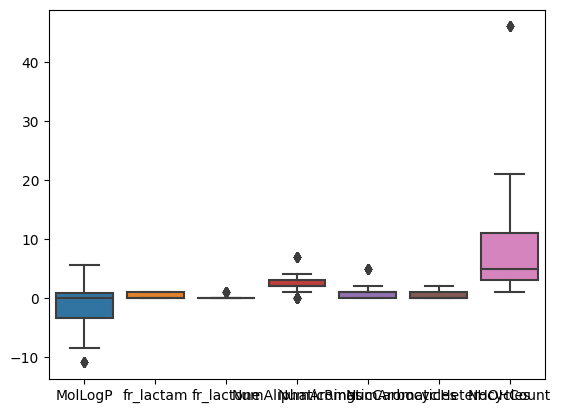

In [ ]:
sns.boxplot(data_df_drug_extended.iloc[:, 10:]) # min-max scaler обязателен
# выброс на Drug_dose на самом деле бимодальное распределени

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

def impute_drug_part(data_df_drug_extended):
    index = data_df_drug_extended.index.copy()
    data_df_drug_extended
    drug_data = data_df_drug_extended.select_dtypes(np.number)

    drug_scaler = MinMaxScaler()
    drug_scaler.fit(drug_data.dropna())
    drug_data_transformed = drug_scaler.transform(drug_data)

    drug_imputer = KNNImputer(n_neighbors=5, weights='distance')
    drug_imputer.fit(
        drug_scaler.transform(drug_data.dropna())
    )
    imputed = drug_imputer.transform(drug_data_transformed)

    imputed_drug_part = pd.DataFrame(
        drug_scaler.inverse_transform(imputed), columns=drug_scaler.get_feature_names_out()
    )
    imputed_drug_part['index'] = index
    imputed_drug_part.set_index('index', inplace=True)
    return imputed_drug_part

# non_numeric = ['Bacteria', 'Drug', 'Drug_class_drug_bank']

imputed_drug_part = impute_drug_part(data_df_drug_extended)
imputed_drug_part.head()

,Drug_dose,ZOI_drug,gram,d_to_Micrococcus luteus,d_to_Neisseria mucosa,d_to_Candida albicans,MolWt,MolLogP,fr_lactam,fr_lactone,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NHOHCount
index,,,,,,,,,,,,,,
4,30.0,0.0,1.0,0.0,14.0,18.0,1449.271,0.1062,0.0,0.0,7.0,5.0,0.0,21.0
5,10.0,0.0,1.0,0.0,14.0,18.0,477.603,-3.3275,0.0,0.0,3.0,0.0,0.0,11.0
177,10.0,19.0,1.0,0.0,14.0,18.0,331.347,1.5833,0.0,0.0,2.0,1.0,1.0,2.0
263,10.0,10.0,1.0,0.0,14.0,18.0,349.412,0.3181,1.0,0.0,2.0,1.0,0.0,4.0
264,10.0,10.0,1.0,0.0,14.0,18.0,349.412,0.3181,1.0,0.0,2.0,1.0,0.0,4.0


### impute np part

In [ ]:
np_cols = ['Bacteria', 'NP_concentration', 'NP size_min', 'NP size_max', 'NP size_avg', 'shape', 'ZOI_NP', 'method']
data_df_np = data_df[np_cols]
data_df_np = data_df_np.drop(data_df_np[data_df_np.ZOI_NP > 3000].index) # три выброса
# и 45 штук где в обоих колонках пропуски


data_df_np_extended = extend_df_with_bacterial_features(data_df_np, bacterial_descriptors_df)
data_df_np_extended.head(2)

,Bacteria,NP_concentration,NP size_min,NP size_max,NP size_avg,shape,ZOI_NP,method,gram,d_to_Micrococcus luteus,d_to_Neisseria mucosa,d_to_Candida albicans
index,,,,,,,,,,,,
4,Micrococcus luteus,100.0,5.0,30.0,21.0,spherical,14.0,disc_diffusion,1,0,14,18
5,Micrococcus luteus,100.0,5.0,30.0,21.0,spherical,14.0,disc_diffusion,1,0,14,18


In [ ]:
# NaN : ZOI_NP, NP_concentration

In [ ]:
# data_df_np.loc[(data_df_np.method == "MIC") & (data_df_np.NP_concentration.isna()) & (~data_df_np.ZOI_NP.isna())].ZOI_NP.plot(kind='hist')

data_df_np_pure = data_df_np.dropna()
print(data_df_np_pure.shape)

part1_mask = (~data_df_np.ZOI_NP.isna()) & (data_df_np.NP_concentration.isna())
part1 = data_df_np[
    part1_mask
]

part2_mask = (data_df_np.ZOI_NP.isna()) & (~data_df_np.NP_concentration.isna())
part2 = data_df_np[
    part2_mask
]
print(part1.shape)
print(part2.shape)


(60, 8)
(123, 8)
(382, 8)


In [ ]:
# data_df_np['mark'] = part1_mask * 1

data_df_np['mark'] = part2_mask * 2
data_df_np['mark'] = data_df_np['mark'].astype(str)

import plotly.express as px

fig = px.density_contour(data_df_np, x="NP_concentration", y="NP size_min", marginal_x="histogram", marginal_y="histogram", color='mark')
fig.show()

# по концентрации part2 весь лежит в узком интервале
# по NP size_min part2 тоже всюду имеет соседей
# так что в принципе его кажется адекатным заполнить

In [ ]:
data_df_np['mark'] = part1_mask * 1
# data_df_np['mark'] = part2_mask * 2
data_df_np['mark'] = data_df_np['mark'].astype(str)

import plotly.express as px

fig = px.density_contour(data_df_np, x="ZOI_NP", y="NP size_min", marginal_x="histogram", marginal_y="histogram", color='mark')
fig.show()

# c part1 всё не так однозначно. Можно попборовать посмотреть на неё ещё раз после заполнения part2

In [ ]:
# # # impute part2
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.impute import KNNImputer

# def impute_np_part2(data_df_drug_extended):
#     index = data_df_drug_extended.index.copy()
#     data_df_drug_extended
#     drug_data = data_df_drug_extended.select_dtypes(np.number)

#     drug_scaler = MinMaxScaler()
#     drug_scaler.fit(drug_data.dropna())
#     drug_data_transformed = drug_scaler.transform(drug_data)

#     drug_imputer = KNNImputer(n_neighbors=5, weights='distance')
#     drug_imputer.fit(
#         drug_scaler.transform(drug_data.dropna())
#     )
#     imputed = drug_imputer.transform(drug_data_transformed)

#     imputed_drug_part = pd.DataFrame(
#         drug_scaler.inverse_transform(imputed), columns=drug_scaler.get_feature_names_out()
#     )
#     imputed_drug_part['index'] = index
#     imputed_drug_part.set_index('index', inplace=True)
#     return imputed_drug_part

# non_numeric = ['Bacteria', 'Drug', 'Drug_class_drug_bank']

# imputed_drug_part = impute_drug_part(data_df_drug_extended)
# # imputed_drug_part.set_index()
# imputed_drug_part

# imputed_drug_part = impute_np_part2(
#     data_df_np_extended[
#         (part1_mask) |
#          ((~data_df_np_extended.ZOI_NP.isna()) & (~data_df_np_extended.NP_concentration.isna()))
#     ]
# )
# imputed_drug_part.info()

In [ ]:
# imputed_drug_part.head()

### what abotut mixed part

In [ ]:
mixed_cols = np_cols[:-2].copy()
mixed_cols.extend(drug_cols[:-2]) # кроме последней
mixed_cols.append("ZOI_drug_NP")

data_df_mixed = data_df.loc[:,mixed_cols]

In [ ]:
data_df_mixed.isna().sum()

Bacteria                253
NP_concentration        421
NP size_min             253
NP size_max             253
NP size_avg             253
shape                   253
Bacteria                253
Drug                    253
Drug_class_drug_bank    253
ZOI_drug_NP             311
dtype: int64

In [ ]:
data_df_mixed.dropna(subset=['ZOI_drug_NP']).isna().sum()

Bacteria                  0
NP_concentration        110
NP size_min               0
NP size_max               0
NP size_avg               0
shape                     0
Bacteria                  0
Drug                      0
Drug_class_drug_bank      0
ZOI_drug_NP               0
dtype: int64

In [ ]:
df_ = data_df_mixed.dropna(subset=['ZOI_drug_NP']).copy()
df_['mark'] = df_.NP_concentration.isna() * 2
df_['mark'] = df_['mark'].astype(str)

import plotly.express as px

fig = px.density_contour(df_, x="ZOI_drug_NP", y="NP size_min", marginal_x="histogram", marginal_y="histogram", color='mark')
fig.show()

# по концентрации part2 весь лежит в узком интервале
# по NP size_min part2 тоже всюду имеет соседей
# так что в принципе его кажется адекатным заполнить